# FRIDA Statistical Analysis


This Jupyter notebook displays the statistical processing of the WAMIDA data. Note that the imported data is only available locally on a host machine and this code will not run without the exact same filename accessible by this notebook

## Method:

Analysis has 3 components

**1. Data Prepocessing and Cleaning**

Data is cleaned, with irrelevant data removed, including analysis of Variance Inflation Factor for colinearity and a confusion matrix to highlight low variance variables. Categorical variables are changed into dummy variables for binary categories.

**2. Exploratory Data Analysis**

We can conduct a Mann-Whitney U test for continuous data and Fisher exact test for binary data. We can also compute Pearson correlation coefficients as well. Note that the p-values are not representative of how significant a logistic fit is (this is what we really want in the end), but this can allow us to be exploratory to see which variables are very viable or very unviable for logistic regression fit.

**3. Logistic Regression, Refactoring Low Significance Variables and Re-fitting**

The remaining significant data is placed into a logistic regression model using a maximum likelihood estimate algorithm. The odds ratio of each variable is reported along with P-value The high-p variables are removed and then logistic regression is re-fitted to achieve a higher accruacy fit. Odds ratios can then be reported.

# 1. Preprocessing

In [1]:
# Setup, imports
import math
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from patsy import dmatrices
import statsmodels.api as sm 
import seaborn as sn
from scipy.stats import wilcoxon, pearsonr, mannwhitneyu
import scipy.stats as stats
from tableone import TableOne
from IPython.display import display


matplotlib.rcParams['figure.figsize'] = [40, 20]
import warnings
warnings.filterwarnings('ignore')

C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


# creating separate dataframes for different groups

In [24]:
#DEAD COLUMN IS CAUSING LOTS OF PROBLEMS, DROPPING FOR NOW

data = pd.read_excel('data_05082022.xlsx')
#added dead to baseline vars
dataBl = data.drop(columns = ['Quit Smoking',
       'Less Drinking', 'New Depression', 'New Anxiety', 'New SUD',
       'F/U Less Social Support', 'Hospitalized', 'Cardiac Rehab',
       'No Intervention', 'Low Emotional/Informational Support',
       'Low Tangible Support', 'Low Affectionate Support',
       'Low Positive Social Interaction', 'Additional Item Low', 'New MACE',
       'HADS Anxiety Score?', 'HADS Depression Score?', 'SF-12 Low',
       'CAQ High', 'Quit smoking 6mo', 'Less drinking 6mo',
       'New Depression 6mo', 'New Anxiety 6 Mo', 'New SUD 6mo',
       'F/U Less Social Support 6mo', 'Hospitalized 6mo',
       'High cholesterol f/u 6mo', 'Diabetes f/u 6mo', 'Hypertension f/u 6mo',
       'Cardiac Rehab 6mo', 'No Intervention 6mo',
       'Low Emotional/Informational Support 6mo', 'Low Tangible Support 6mo',
       'Low Affectionate Support 6mo', 'Low Positive Social Interaction 6mo',
       'Additional Item Low 6mo', 'New MACE 6mo', 'HADS Anxiety Score?.1',
       'HADS Depression Score?.1', 'SF-12 Low 6mo', 'CAQ High 6mo', 
       'SSS Score?'])
data3m = data.drop(columns = ['Quit smoking 6mo', 'Less drinking 6mo',
       'New Depression 6mo', 'New Anxiety 6 Mo', 'New SUD 6mo',
       'F/U Less Social Support 6mo', 'Hospitalized 6mo',
       'High cholesterol f/u 6mo', 'Diabetes f/u 6mo', 'Hypertension f/u 6mo',
       'Cardiac Rehab 6mo', 'No Intervention 6mo',
       'Low Emotional/Informational Support 6mo', 'Low Tangible Support 6mo',
       'Low Affectionate Support 6mo', 'Low Positive Social Interaction 6mo',
       'Additional Item Low 6mo', 'New MACE 6mo', 'HADS Anxiety Score?.1',
       'HADS Depression Score?.1', 'SF-12 Low 6mo', 'CAQ High 6mo', 'Dead.1',
       'SSS Score?', 'Dead'])
data6m = data.drop(columns = ['Dead','Dead.1'])

outcomesBl = ['HADS-A>7', 'HADS-D>7']
outcomes3m = ['New MACE', 'HADS Anxiety Score?',
             'HADS Depression Score?', 'SF-12 Low', 'CAQ High']
outcomes6m = ['HADS-A>7', 'HADS-D>7','New MACE 6mo', 'HADS Anxiety Score?.1', 
             'HADS Depression Score?.1', 'SF-12 Low 6mo', 
             'CAQ High 6mo', 'SSS Score?']

dataBl =dataBl.dropna(axis=0)
data3m =data3m.dropna(axis=0)
data6m =data6m.dropna(axis=0)

colsNum = ['Age']
dataBlNum = dataBl[colsNum + outcomesBl]
dataBlCat = dataBl.drop(columns = colsNum)
data3mNum = data3m[colsNum + outcomes3m]
data3mCat = data3m.drop(columns = colsNum)
data6mNum = data6m[colsNum + outcomes6m]
data6mCat = data6m.drop(columns = colsNum)


data6m

,Age,Non-White,Indigenous,Non-Woman Gender,Less than highschool,Unemployed,<$20k Income,Marital status,Unstable Housing,Smoker,...,Low Tangible Support 6mo,Low Affectionate Support 6mo,Low Positive Social Interaction 6mo,Additional Item Low 6mo,New MACE 6mo,HADS Anxiety Score?.1,HADS Depression Score?.1,SF-12 Low 6mo,CAQ High 6mo,SSS Score?
0,66,1,0,1,0,0,1,1,1,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,74,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,68,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
6,61,1,0,0,0,1,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,60,1,1,0,0,0,0,0,0,1,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
9,58,0,0,0,1,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
10,77,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11,72,0,0,0,0,0,0,0,0,0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12,36,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [25]:
# data = pd.read_excel('frida.xlsx')
# #tempporary 2nd dataframe wiht followup data
# dataFollow = data
# #dropping irrelevant or incomplete columns
# data = data.drop(columns = ['Study ID', 'Deceased', 'New Depression','New Anxiety','Cardiac Rehab',
#                            'SF-12','Cardiac Anxiety','MOS Score' ])
# dataFollow = dataFollow.drop(columns = ['Study ID', 'Deceased', 'New Depression','New Anxiety','Cardiac Rehab',
#                            'SF-12','Cardiac Anxiety','MOS Score'])
# data = data.replace({0:1, 1:0})
# dataFollow = dataFollow.replace({0:1, 1:0})
# #columns with less than 100 non NaN values then drop rows with missing values
# data = data.dropna(axis = 1, how='all')
# #data = data.dropna(axis = 0)
# dataFollow = dataFollow.dropna(axis = 1, how='all')
# #dataFollow = dataFollow.dropna(axis=0)

# #female data only, have to drop columsn with same values or else crosstab fiails later, can remove with more samples
# dataFemale = data.drop(data[data.Sex ==  0].index).drop(columns=['Sex', 'Hx Substance Use Disorder'])
# dataFollowFemale = dataFollow.drop(dataFollow[data.Sex ==  0].index).drop(columns=['Sex', 'Hx Substance Use Disorder'])

# #Age has a space afterward in the spreadsheet,
# cols_num = ['Age ', 'Pack Years', 'Drinks/Week', 'BMI']
# data_num = data[cols_num]
# data_cat = data.drop(columns = cols_num)
# columns = list(data)
# dataFemale

# Exploratory Data Analysis

## Testing Colinearity with Variance Inflation Factor, colinear variables would not be of statistical value and would be removed for a regression fit 


In [26]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def calc_vif(X):

#     # Calculating VIF
#     vif = pd.DataFrame()
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#     return(vif)

# X = data.iloc[:,:-3].dropna()
# calc_vif(X)


## Before the first exlusion of features, for instance, BMI was colinear with height and weight. Any collinear variables should be excluded. At this point, all VIF is < 10, which means low collinearity, although some papers argue whether the threshold should be 10 or 5 etc.

## We can visualize pearson correlation of the with a correlation matrix 

In [27]:
# corrMatrix = data.corr()
# fig = sn.heatmap(corrMatrix, annot=True)
# plt.show()
# corrMatrix

# Independent p-values

## We can do some biostat faves and look at MWU values for continuous (comparing to HADS A and HADS D, quasi-continuous, really, since it's all integer data) and Fisher values (comparing to 0/1 of depression or no depression) for binary data. 

## The value of this is that the p-values tell us if the distributions of variables between positive vs. negative outcome has *some significant difference*. This is still valuable to report though there are two mathematical caveats to keep in mind:

1. The p-values look at variables independently. If the relationship can be sufficiently analyzed by linear correlation analysis, then this is great. If the variables are dependent on each other, then there is a chance the traditional p-value may come to a false conclusion. For instance, if pack years is a random predictor by itself but is a strong positive predictor only when drinks/week is within some range, then the p-value would false report that pack years is not significant differently distributed between the outcomes.

2. A p<0.05 (the traditional threshold) tells us the two distributions (e.g. pack years for positive depression vs. pack years for negative depression) has *some significant difference*. This is great for observational statistics ("this variable is important to look at") but requires more work for inferential statistics ("we can use this variable by this weighing formula to predict the outcome") because it doesn't tell us the mathematical nature of the relationship between variables and outcome. Hence, the we can utilize the p-value in two ways: to state that a variable may be significant from an initial linear, independent view and to use as a first-pass filtering of variables if we don't have enough samples to build a model.

# Two-Tailed T-Test for Continuous Data

## For the variables that are unpaired, continuous, Gaussian (theoretically it should be Gaussian by central limit theorem with enough samples), we can do a T-test for association  (Mann-Whitney test can be used if not enough samples, can't do Wilcoxon because variables are different length)

In [28]:
def ttest(data, outcomes):
    results = []
    
    # extraction variable values for positive and negative outcomes
    for o in outcomes:
        negOutcome = []
        posOutcome = []
        temp = data.drop(columns = [o])
        columns = data.columns.values.tolist()
        for col in columns:
            for row,val in data[col].iteritems():
                variableVal = data[col][row]
                if data[o][row] == 0:
                    negOutcome.append(variableVal)
                else:
                    posOutcome.append(variableVal)
            u, p = stats.ttest_ind(negOutcome,posOutcome)
            results.append([o, col, p])

    return results
        

In [29]:
tBl = ttest(dataBlNum, outcomesBl)
t3m = ttest(data3mNum, outcomes3m)
t6m = ttest(data6mNum, outcomes6m)

tBlDF = pd.DataFrame(tBl, columns = ['outcome', 'variable', 'p-value'])
t3mDF = pd.DataFrame(t3m, columns = ['outcome', 'variable', 'p-value'])
t6mDF = pd.DataFrame(t6m, columns = ['outcome', 'variable', 'p-value'])

tBlDF.to_csv('tBl.csv', index=False)  
t3mDF.to_csv('t3m.csv', index=False)  
t6mDF.to_csv('t6m.csv', index=False)  

In [30]:

# TResults = []
# print('T-test p values for continuous data, comparing distributions of variable values for positive vs. negative outcomes: \n')
# for cols in data_num.columns:
#     posOutcomeAnx = []
#     negOutcomeAnx = []
#     posOutcomeDep = []
#     negOutcomeDep = []
#     posOutcomeCV = []
#     negOutcomeCV = []
#     if ((cols != 'HADS A') and (cols != 'HADS D') and (cols != 'CV Event ')) :
#         for row,val in data_num[cols].iteritems():
#             variableVal = data_num[cols][row]
#             if data_cat['HADS A'][row] == 0:
#                 negOutcomeAnx.append(variableVal)
#             else:
#                 posOutcomeAnx.append(variableVal)
#             if data_cat['HADS D'][row] == 0:
#                 negOutcomeDep.append(variableVal)
#             else:
#                 posOutcomeDep.append(variableVal)
#             if data_cat['CV Event '][row] == 0:
#                 negOutcomeCV.append(variableVal)
#             else:
#                 posOutcomeCV.append(variableVal)
#         uDep, pAnx = stats.ttest_ind(negOutcomeAnx,posOutcomeAnx)
#         uDep, pDep = stats.ttest_ind(negOutcomeDep,posOutcomeDep)
#         uCV, pCV = stats.ttest_ind(negOutcomeCV, posOutcomeCV)
    
#         TResults.append([cols, pAnx, pDep, pCV])

# Tdf = pd.DataFrame(TResults, columns = ['cols', 'pAnx','pDep', 'pCV'])
# print(Tdf)

P-values for continuous variables are quite bad. This is not to say the variables aren't significant, just that under the current dataset shows little linear independent significance. We can still use some data science techniques for predictabilitiy later on.

Perhaps because distributions of data are not Gaussian (they should be if we have enough samples under CLT) as that signifies not enough data has been collected to analyze these variables using techniques that rely on randomizations being balance under a Gaussian distribution (i.e. almost all p-value tests)

# For the binary variables, we use Fisher's Exact Test

## We have to create contingency tables for each variables with respect to the outcome (binary anxiety or binary depression outcomes), then compute the Fisher exact test odds ratio and p-value

In [31]:
def fisherTest(data, outcomes):
    results = []
    for o in outcomes:
        for cols in data.columns:
            data_crosstab = pd.crosstab(data[cols],data[o])
            odds, p = stats.fisher_exact(data_crosstab)

            results.append([o, cols, odds, p])

    resultsDF = pd.DataFrame(results, columns = ['outcome', 'variable', 'fisher odds',
                                                 'p-value'])
    return resultsDF

In [32]:
fBlDF = fisherTest(dataBlCat, outcomesBl)
f3mDF = fisherTest(data3mCat, outcomes3m)
f6mDF = fisherTest(data6mCat, outcomes6m)

fBlDF.to_csv('fBlDF.csv', index=False)  
f3mDF.to_csv('f3mDF.csv', index=False)  
f6mDF.to_csv('f6mDF.csv', index=False)  

In [33]:
# print('Fisher exact test values: \n')

# fisherResults =[ ]

# for cols in data_cat.columns:
#     data_crosstabAnx = pd.crosstab(data_cat[cols],data_cat['HADS A'])
#     data_crosstabDep = pd.crosstab(data_cat[cols],data_cat['HADS D'])
#     data_crosstabCV = pd.crosstab(data_cat[cols],data_cat['CV Event '])
#     orAnx, pAnx = stats.fisher_exact(data_crosstabAnx)
#     orDep, pDep = stats.fisher_exact(data_crosstabDep)
#     orCV, pCV = stats.fisher_exact(data_crosstabCV)
    
#     fisherResults.append([cols, orAnx, pAnx, orDep, pDep, orCV, pCV])
    
# fisherdf = pd.DataFrame(fisherResults, columns = ['cols', 'orAnx', 'pAnx','orDep','pDep', 'orCV','pCV'])
# print(fisherdf)

## We can also do a basic linear odds ratio calculation

In [34]:
def getOddsRatios(data, outcomes):
    
    results  = []
    for o in outcomes:
        for cols in data.columns:
            data_crosstab = pd.crosstab(data[cols],data[o])
            tp = data_crosstab.iloc[1][1]
            tn = data_crosstab.iloc[0][0]
            fp = data_crosstab.iloc[1][0]
            fn = data_crosstab.iloc[0][1]
            if(tp == 0 or tn == 0 or fp == 0 or fn == 0):
                tp = tp + 0.5
                tn = tn + 0.5
                fp = fp + 0.5
                fn = fn + 0.5

            linOR = (tp*tn)/(fp*fn)
            SE = math.sqrt(1/tp + 1/tn + 1/fp + 1/fn)
            z = math.log(linOR)/SE
            #dont take exponential fo rnow
            CILow = math.exp(math.log(linOR) - 1.96*SE)
            CIHigh = math.exp(math.log(linOR) + 1.96*SE)
            p=stats.norm.sf(abs(z))*2

            results.append([o, cols, linOR, CILow, CIHigh, p])
            
    resultsDF = pd.DataFrame(results, columns = ['outcome', 'variable', 'OR',
                                                 'CILow','CIHigh','p'])
    return resultsDF

In [35]:
ORBlDF = getOddsRatios(dataBl, outcomesBl)
OR3mDF = getOddsRatios(data3m, outcomes3m)
OR6mDF = getOddsRatios(data6m, outcomes6m)

ORBlDF.to_csv('ORBl.csv', index=False)  
OR3mDF.to_csv('OR3m.csv', index=False)  
OR6mDF.to_csv('OR6m.csv', index=False)  

In [36]:
# ORDep = getOddsRatios(data, 'HADS D')
# ORAnx = getOddsRatios(data, 'HADS A')
# ORCV = getOddsRatios(data, 'CV Event ')
# ORDepF = getOddsRatios(dataFemale, 'HADS D')
# ORAnxF = getOddsRatios(dataFemale, 'HADS A')
# ORCVF = getOddsRatios(dataFemale, 'CV Event ')

# ORDepFollow = getOddsRatios(dataFollow, 'HADS-D F/U')
# ORAnxFollow = getOddsRatios(dataFollow, 'HADS-A F/U')
# ORDepFollowF = getOddsRatios(dataFollowFemale, 'HADS-D F/U')
# ORAnxFollowF = getOddsRatios(dataFollowFemale, 'HADS-A F/U')

# ORDepDF = pd.DataFrame(ORDep, columns = ['col','OR','CILow','CIHigh','p'])
# ORAnxDF = pd.DataFrame(ORAnx, columns = ['col','OR','CILow','CIHigh','p'])
# ORCVDF = pd.DataFrame(ORCV, columns = ['col','OR','CILow','CIHigh','p'])
# ORDepDFFollow = pd.DataFrame(ORDepFollow, columns = ['col','OR','CILow','CIHigh','p'])
# ORAnxDFFollow = pd.DataFrame(ORAnxFollow, columns = ['col','OR','CILow','CIHigh','p'])

# #female only
# ORDepDFF = pd.DataFrame(ORDepF, columns = ['col','OR','CILow','CIHigh','p'])
# ORAnxDFF = pd.DataFrame(ORAnxF, columns = ['col','OR','CILow','CIHigh','p'])
# ORCVDFF = pd.DataFrame(ORCVF, columns = ['col','OR','CILow','CIHigh','p'])
# ORDepDFFollowF = pd.DataFrame(ORDepFollowF, columns = ['col','OR','CILow','CIHigh','p'])
# ORAnxDFFollowF = pd.DataFrame(ORAnxFollowF, columns = ['col','OR','CILow','CIHigh','p'])


# print('HADS D: \n')
# print(ORDepDF)
# print('HADS A: \n')
# print(ORAnxDF)
# print('CV Event: \n')
# print(ORCVDF)
# print('HADS D Followup: \n')
# print(ORDepDFFollow)
# print('HADS A Followup: \n')
# print(ORAnxDFFollow)


## 3. Initial Attempt at Logistic Regression

## First removing colinear variables, similar to above. Note that categorical variables are not defined for VIF, colinearity is not well understood for those

## Removing low-variance variables 

In [37]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.1):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    
    return data[data.columns[selector.get_support(indices=True)]]


# Logistic Regression (odds ratios are adjusted for all other covariates)

Remember to to e^(coefficient) to get odds ratios

In [38]:
def fitLogReg(data, outcomes):
    #removing low variance columns
    dataTemp = variance_threshold_selector(data, 0.1) 

    for o in outcomes:
        data = dataTemp
        print('\n Outcome: ' + o + '\n')
        maxParams = math.floor(len(data)/10)
        #dropping outcomes
        outcomeCol = data[o]
        #dropping outcomes columns
        data = data.drop(columns = outcomes)
        data[o] = outcomeCol

        #first logit fit
        y = data[o]
        X = data.drop(columns = [o])
        logit_model=sm.Logit(y,X)
        result=logit_model.fit()
        print(result.summary2())

        #refitting with feature selection of top N features
        print('Refitting after feature selection \n')
        toDrop = len(X.columns) - maxParams
        LRresult = (result.summary2().tables[1])
        resultDropped = LRresult.drop(LRresult['P>|z|'].nlargest(toDrop).index)
        cols = resultDropped.index

        XFiltered = data[cols]
        logit_model=sm.Logit(y,XFiltered)
        result=logit_model.fit()
        print(result.summary2())
        LRresult = (result.summary2().tables[1])




In [40]:
outcomesBlNoDead = ['HADS-A>7', 'HADS-D>7']
print('\n BASELINE \n \n')
fitLogReg(dataBl.drop(columns=['Dead','Dead.1']), outcomesBlNoDead)
print('\n 3MONTH \n \n')
fitLogReg(data3m.drop(columns=[
       'Less Drinking', 'New Depression', 'New Anxiety', 'New SUD',
       'F/U Less Social Support', 'Hospitalized', 'Cardiac Rehab',
       'No Intervention', 'Low Emotional/Informational Support',
       'Low Tangible Support', 'Low Affectionate Support',
       'Low Positive Social Interaction']), outcomes3m)
print('\n 6MONTH \n \n')
fitLogReg(data6m.drop(columns=['Health Anxiety', 'COVID Health Anxiety',
       'COVID Wait', 'COVID Lonely', 'Stressors', 'Menopause',
       'Complicated Pregnancy', 'Hx Stroke', 'Hx ACS', 'Hx CABG/stent',
       'High cholesterol', 'Diabetes', 'Hypertension', 'Obese', 'eGFR <60',
       'LVEF <55', 'STEMI', 'ESSI Low', 'Quit Smoking',
       'Less Drinking', 'New Depression', 'New Anxiety', 'New SUD',
       'F/U Less Social Support', 'Hospitalized', 'Cardiac Rehab',
       'No Intervention', 'Low Emotional/Informational Support',
       'Low Tangible Support', 'Low Affectionate Support',
       'Low Positive Social Interaction', 'Additional Item Low', 'New MACE',
       'HADS Anxiety Score?', 'HADS Depression Score?', 'SF-12 Low',
       'CAQ High', 'Quit smoking 6mo', 'Less drinking 6mo',
       'New Depression 6mo', 'New Anxiety 6 Mo', 'New SUD 6mo',
       'F/U Less Social Support 6mo', 'Hospitalized 6mo',
       'High cholesterol f/u 6mo', 'Diabetes f/u 6mo', 'Hypertension f/u 6mo',
       'Cardiac Rehab 6mo', 'No Intervention 6mo',
       'Low Emotional/Informational Support 6mo', 'Low Tangible Support 6mo',
       'Low Affectionate Support 6mo', 'Low Positive Social Interaction 6mo',
       'Additional Item Low 6mo']), outcomes6m)


 BASELINE 
 


 Outcome: HADS-A>7

Optimization terminated successfully.
         Current function value: 0.540191
         Iterations 6
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.212     
Dependent Variable:   HADS-A>7          AIC:               314.6935  
Date:                 2022-05-30 15:45  BIC:               402.2250  
No. Observations:     245               Log-Likelihood:    -132.35   
Df Model:             24                LL-Null:           -167.85   
Df Residuals:         220               LLR p-value:       1.5327e-06
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       6.0000                                         
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Age                   -0.0181   0.0071 -2.5369 0.0

Optimization terminated successfully.
         Current function value: 0.428242
         Iterations 7
                           Results: Logit
Model:              Logit               Pseudo R-squared: 0.351     
Dependent Variable: HADS Anxiety Score? AIC:              118.7828  
Date:               2022-05-30 15:45    BIC:              148.7840  
No. Observations:   113                 Log-Likelihood:   -48.391   
Df Model:           10                  LL-Null:          -74.562   
Df Residuals:       102                 LLR p-value:      9.8621e-08
Converged:          1.0000              Scale:            1.0000    
No. Iterations:     7.0000                                          
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Smoker               -0.9060   0.6114 -1.4819 0.1384 -2.1044  0.2923
COVID Wait            1.1939

Optimization terminated successfully.
         Current function value: 0.587503
         Iterations 5
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.151   
Dependent Variable: HADS-A>7         AIC:              68.7503 
Date:               2022-05-30 15:45 BIC:              78.3104 
No. Observations:   50               Log-Likelihood:   -29.375 
Df Model:           4                LL-Null:          -34.617 
Df Residuals:       45               LLR p-value:      0.033013
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
---------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------
Age             -0.0229   0.0089 -2.5819 0.0098 -0.0403 -0.0055
Non-White        1.6089   0.8277  1.9438 0.0519 -0.0133  3.2312
Marital status   1.0885   0

Optimization terminated successfully.
         Current function value: 0.587257
         Iterations 6
                          Results: Logit
Model:                 Logit             Pseudo R-squared:  0.152  
Dependent Variable:    SF-12 Low 6mo     AIC:               74.7257
Date:                  2022-05-30 15:45  BIC:               90.0219
No. Observations:      50                Log-Likelihood:    -29.363
Df Model:              7                 LL-Null:           -34.617
Df Residuals:          42                LLR p-value:       0.16152
Converged:             1.0000            Scale:             1.0000 
No. Iterations:        6.0000                                      
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------
Age                   0.0079   0.0084  0.9364 0.3491 -0.0086 0.0243
Non-White            -1.0714   0.8376 -1.

# Classification and Regression Tree Approach

## The problem proposed (e.g. need variables to associated with an outcome) is a classic machine learning classification problem. The clinical goal proposed (e.g. come up with some screening algorithm, with variables of unknown importance) is fit for a parametric nonlinear model with feature selection (i.e. not logistic regression). Below is an example of one of these models: a decision tree optimized by the CART algorithm. It is not state of the art (random forest would be a "modern" form of it, but can be explored to test predictability of the variables. One bonus is that the result is like a "flowchart", which is familiar to clinical experts, rather than an equation.).

In [81]:
from sklearn.tree import DecisionTreeClassifier  
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import RocCurveDisplay, auc
import graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
%matplotlib inline

In [137]:
def fitDT(data, outcome, max_features = 10, k = 5, max_depth = 6):

    #performing select k best by mutual info score, dropping all outcome columns
    #can chang e later if we want to keep outcome columns as an independent variable
    X = data.drop(columns = ['HADS D', 'HADS A', 'CV Event '])
    y = data[outcome]
    selector = SelectKBest(mutual_info_classif, k = max_features)
    selector.fit(X, y)
    

    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    data = X.iloc[:,cols]
    data[outcome] = y

    y = data[outcome].astype(int)
    X = data.drop(columns = [outcome])
    kf=StratifiedKFold(n_splits=k, random_state=42, shuffle=True)

    sens = []
    spec = []
    acc = []
    # have to name auc aucVal beacuse auc is the library name
    aucVal = []
    imps = []
    i = 1
    tprs = []
    aucs = []
    fig, ax = plt.subplots(figsize=(6,3.75))
    mean_fpr = np.linspace(0, 1, 100)
    
    print(data.columns)
    for trainIdx, testIdx in kf.split(X,y):

        XTrain, XTest = X.iloc[trainIdx], X.iloc[testIdx]
        yTrain, yTest=y.iloc[trainIdx], y.iloc[testIdx]

        #building model
        tree = DecisionTreeClassifier(max_depth=max_depth,random_state=42)
        tree.fit(XTrain,yTrain)

        # feature importances
        imps.append(tree.feature_importances_)
        #metrics
        preds = tree.predict(XTest)
        tn, fp, fn, tp = confusion_matrix(yTest, preds).ravel()
        sens.append(tp/(tp+fn))
        spec.append(tn/(tn+fp))
        acc.append((tp+tn)/(tp+tn+fp+fn))
        aucVal.append(roc_auc_score(yTest, tree.predict(XTest)))
        
        viz = RocCurveDisplay.from_estimator(
        tree,
        XTest,
        yTest,
        name="ROC fold {}".format(i),
        alpha=0.5,
        lw=1,
        ax=ax,
            
        )
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
        i = i+1

    # plotting AUC ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )
    ax.legend(loc="lower right")
    plt.show()

    #showi ndecision tree graphic
    
    filename = outcome + ".dot"
    graph = Source(export_graphviz(tree, out_file=filename, class_names=['Positive ' +
                                                                         outcome,'Negative ' + outcome], feature_names=X.columns, impurity=False, filled=True))
    #show decision tree, only do this if graphviz is installed to system PATH
    #SVG(graph.pipe(format='svg'))
    return sens, spec, acc, aucVal, imps

Index(['Ethnicity', 'Sex', 'Employment', 'Hx Depression', 'Hx Anxiety ',
       'Stroke History', 'Previous AMI', 'High Cholesterol', 'HADS A'],
      dtype='object')


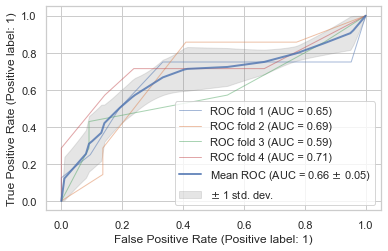

Index(['Ethnicity', 'Income (2019)', 'Pack Years', 'Drinks/Week',
       'Hx Substance Use Disorder', 'Hx Anxiety ', 'High Cholesterol', 'BMI',
       'HADS D'],
      dtype='object')


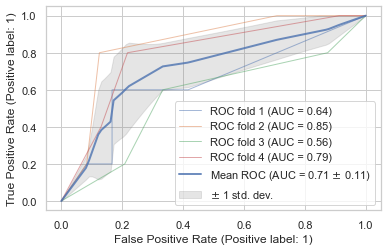

Index(['Sex', 'Education Level', 'Married?', 'Pack Years', 'Hx Anxiety ',
       'Stroke History', 'Previous AMI', 'Previous Stent/CABG', 'CV Event '],
      dtype='object')


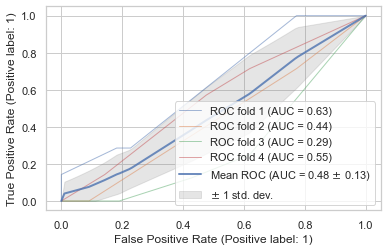

,Outcome,Sens Mean,Sens Std,Spec Mean,Spec Std,Acc Mean,Acc Std,Auc mean,Auc std
0,HADS A,0.375000,0.170346,0.871212,0.052453,0.748153,0.025855,0.623106,0.065569
1,HADS D,0.300000,0.173205,0.841938,0.045926,0.748153,0.043099,0.570969,0.085057
2,CV Event,0.071429,0.123718,0.942641,0.074440,0.721983,0.032471,0.507035,0.027693


In [147]:
results= []
max_features = 8
k_folds = 4
max_depth = 4
sensAnx, specAnx, accAnx, aucValAnx, impsAnx = fitDT(data_final, 'HADS A', max_features = max_features, k = k_folds, max_depth = max_depth)
sensDep, specDep, accDep, aucValDep, impsDep = fitDT(data_final, 'HADS D', max_features = max_features, k = k_folds, max_depth = max_depth)
sensCV, specCV, accCV, aucValCV, impsCV = fitDT(data_final, 'CV Event ', max_features = max_features, k = k_folds, max_depth = max_depth)


results.append(['HADS A', np.mean(sensAnx), np.std(sensAnx), np.mean(specAnx), np.std(specAnx), 
               np.mean(accAnx), np.std(accAnx), np.mean(aucValAnx), np.std(aucValAnx)])
results.append(['HADS D', np.mean(sensDep), np.std(sensDep), np.mean(specDep), np.std(specDep), 
               np.mean(accDep), np.std(accDep), np.mean(aucValDep), np.std(aucValDep)])
results.append(['CV Event', np.mean(sensCV), np.std(sensCV), np.mean(specCV), np.std(specCV), 
               np.mean(accCV), np.std(accCV), np.mean(aucValCV), np.std(aucValCV)])

resultsDF = pd.DataFrame(results, columns = ['Outcome', 'Sens Mean', 'Sens Std', 'Spec Mean', 'Spec Std',
                                            'Acc Mean', 'Acc Std', 'Auc mean', 'Auc std'])
resultsDF


In [ ]:
# # Print the features and their importance for the  decision tree
# print('Feature importances: {}'.format(treeAnx.feature_importances_))
# type(treeAnx.feature_importances_)

# #Plot feature importance
# n_feature = features.shape[1]
# fig = plt.figure(figsize=(10,8))
# plt.barh(range(n_feature), treeAnx.feature_importances_, align='center')
# plt.yticks(np.arange(n_feature), features)
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.show()

# CART Summary:

## Even with the limited sample size, the machine learning approach shows decent accuracy (in this case accuracy is measured by the Jaccard index) of ~0.85, defined below.

<img src = "https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7" />

## Excellent models have ~0.90 accuracy so this is a good start. Further complex models like a random forest may provide greater accuracies in the future but requires refining of the input features to prevent overfitting.